In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pybamm
import liionpack as lp

Minimum Viable Product:

1. Battery Pack of LG M50 Batteries w/ Parameters from Chen2020 Dataset
(Use liionpack to describe circuit configuration)

2. A way to represent both charge/discharge data (solar panel power production & system loads),
and run experiments with that data

3. A way to plot relevant pack variables against each other

3. Validation against a test datasheet for our specific battery (LG MJ 1)
    
5. Battery degradation, either through a physics-based mechanism, or through some other
rule (need to further consult PyBaMM Docs for more info on this)

Things that would be nice:

1. Consideration of thermal effects based

In [100]:
# Some preliminary example functions for charging and load data

# roughly square wave function, plus some smoothing
def power_wave(input_times, period=1, time_on=0.6, amplitude=1):
    normalized_time = (input_times % period) / period
    return amplitude * np.heaviside(normalized_time - (1 - time_on), 0.5)


In [ ]:
# Currently, charging_data[i] is the current being provided by the solar panels,
# from (10*i) seconds to 10*(i+1) seconds, and likewise load_data[i] is the
# discharge current from time = 10*i to time = 10(i+1)

num_orbits = 10

orbit_duration = 90 # minutes
sampling_rate = 6 # updates / min

times = np.linspace(0, num_orbits * orbit_duration, num_orbits * orbit_duration * sampling_rate)

# Assuming we get 1.4 A from panels,
# and load is either 1.02 A (eclipse) or 0.6 A (sun), depending on whether heaters are on
net_charge = power_wave(times, period=orbit_duration, time_on=0.65, amplitude=1.82) - 1.02


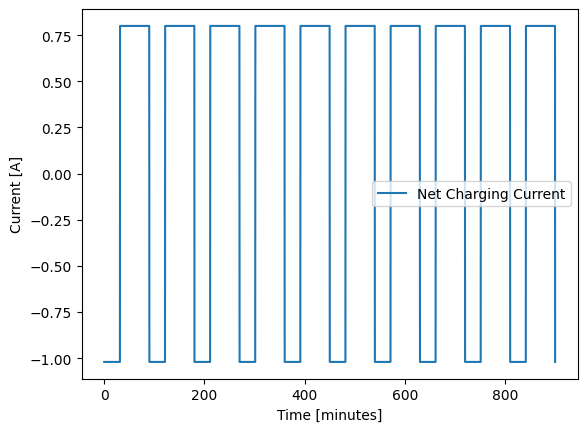

In [111]:
plt.plot(times, net_charge, label="Net Charging Current")
plt.xlabel("Time [minutes]")
plt.ylabel("Current [A]")
plt.legend()
plt.show()

In [112]:
# Pick a set of Parameters (Until something better comes along, we will use Chen 2020)
params = pybamm.ParameterValues('Chen2020')

start_voltage = params['Open-circuit voltage at 100% SOC [V]'] * 0.5

# TODO: I think we should also add an initial short circuit current?

In [ ]:
# Relevant Chen2020 parameters we can consider tweaking are:
# 'Current function [A]
# 'Nominal cell capacity [A.h]'
# 'Upper voltage cut-off [V]'
# 'Open-circuit voltage at 100% SOC [V]'

# In particular, we should compare these parameters (which are for the LG M50) to our battery

In [114]:
# Initialize pack configuration

series = 6
parallel = 1
num_cells = series * parallel

oc_voltage_init = series * start_voltage

i_mag = 8.0 
# TODO: I know this is the value of a current source in the circuit diagram, but IDK what it does

wire_resistance = 1e-3 # internal resistance of connections between batteries

netlist = lp.setup_circuit(Np=parallel, Ns=series, 
                           Rb=wire_resistance, Rc=wire_resistance, Ri=wire_resistance,
                           V=oc_voltage_init, I=i_mag)

In [115]:
# Setup an experiment that accurately represents subsystem loads and power we're getting

experiment = pybamm.Experiment(
    [
        (
            f"Discharge at {-current} A for {60 / sampling_rate} seconds",
        ) if current < 0 else (
            f"Charge at {current} A for {60 / sampling_rate} seconds",
        ) for current in net_charge
    ],
    period = f"{60 / sampling_rate} seconds" # good practice to have this the same as 60 / sampling rate
)

# TODO add extra simulation params to get something more realistic - check documentation

Stepping simulation:  49%|████▉     | 2650/5401 [00:24<00:25, 108.61it/s]


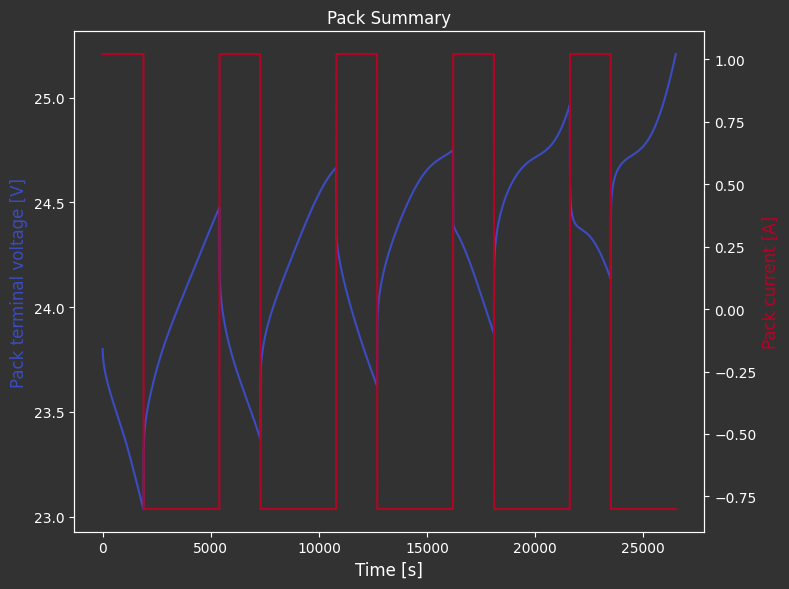

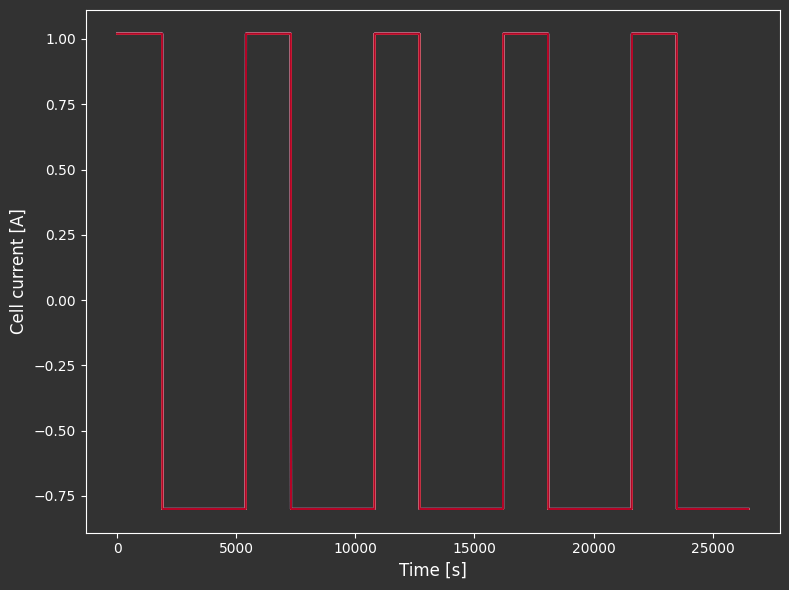

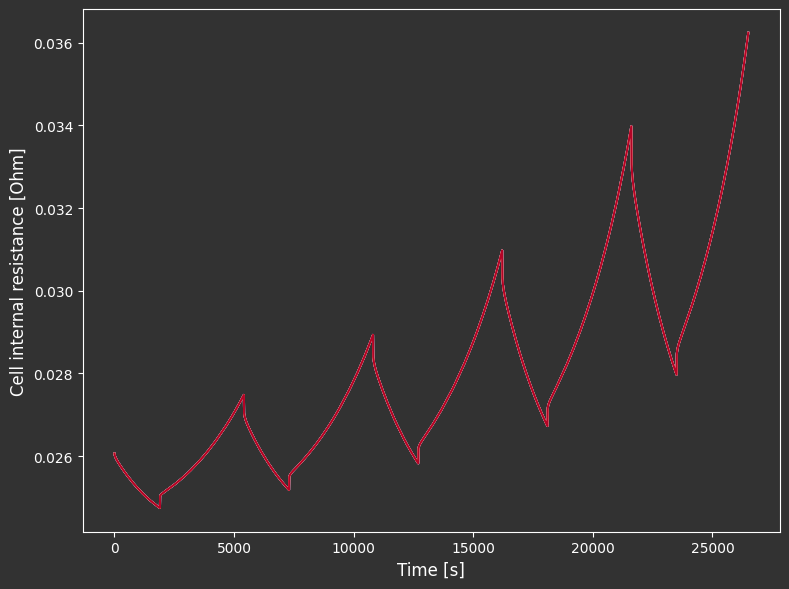

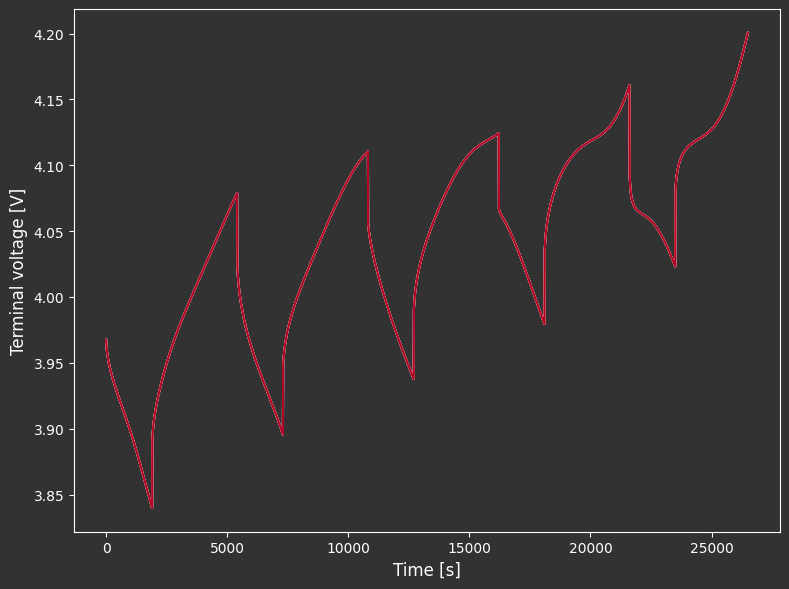

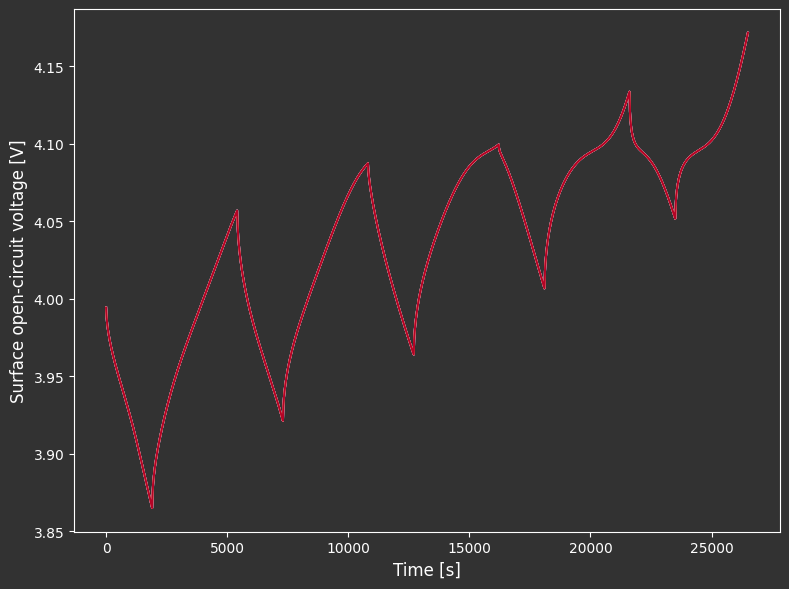

In [ ]:
# Create a simulation for the experiment, solve it, then plot some useful stuff

# TODO: currently this does nothing - figure out how to add (non default) model to solver
SPMe = pybamm.models.full_battery_models.lithium_ion.SPMe() 
# TODO: add DFN model, do multiplot to compare models

output = lp.solve(
    netlist=netlist,
    parameter_values=params,
    experiment=experiment,
    initial_soc=0.75
) 

lp.plot_output(output)